# Imports

In [1]:
import torch
import torch.nn as nn
from botorch.models.model import Model
from botorch.models.gpytorch import GPyTorchModel
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement
from botorch.optim import optimize_acqf
# from botorch.utils.multi_objective.box_decomposition import NondominatedPartitioning
from botorch.utils.sampling import sample_simplex
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.test_functions.multi_objective import BraninCurrin
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.mlls.variational_elbo import VariationalELBO
from gpytorch.likelihoods import GaussianLikelihood
from torch.optim import Adam
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from botorch.optim import optimize_acqf_discrete
from botorch.acquisition.multi_objective import ExpectedHypervolumeImprovement
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float64
torch.set_default_dtype(dtype)

print(device)

cpu


In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import os
import time
import pickle
import cv2

from tqdm import tqdm
import aespm as ae


# Define MOBO-DKL

In [3]:
import gpytorch
from botorch.posteriors.gpytorch import GPyTorchPosterior
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
import math
import torch.nn as nn
import numpy as np
from typing import Tuple, Optional, Dict, Union, List
import numpy as np
import torch

# Simple ConvNet for feature extraction
class ConvNetFeatureExtractor(nn.Module):
    def __init__(self, input_channels=1, output_dim=32):
        super(ConvNetFeatureExtractor, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.output_dim = output_dim
        self.fc = None  # Placeholder for the fully connected layer

    def forward(self, x):
        if len(x.shape) == 3: # TODO: hacky way to make sure botorch acquisition function works
            # flatten
            batch_size, channel, mn = x.shape[0], x.shape[1] , x.shape[2]
            d = math.sqrt(mn)      ## TODO: what if mn is not a perfect square?
            x = x.reshape(int(batch_size), int(channel), int(d), int(d))
        # Pass through the convolutional layers
        x = self.conv_layers(x)

        # If the fully connected layer is not defined yet, initialize it dynamically******************key
        if self.fc is None:
            flattened_size = x.view(x.size(0), -1).size(1)
            device = x.device# TODO: better way to handle device
            self.fc = nn.Linear(flattened_size, self.output_dim).to(device)  # Create fc layer on the correct device

        # Flatten for fully connected layer
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# GP model with deep kernel using ConvNet feature extractor
class GPModelDKL(ApproximateGP, Model):
    def __init__(self, inducing_points, likelihood, feature_extractor=None, input_shape=(1, 5, 5)):
        self.input_shape = input_shape

        # Transform inducing points first
        flat_inducing = self._flatten_input(inducing_points)
        feature_inducing = feature_extractor(self._reshape_to_patch(flat_inducing))
        # No need to reshape feature_inducing as it's already in correct shape

        variational_distribution = CholeskyVariationalDistribution(feature_inducing.size(0))
        variational_strategy = VariationalStrategy(
            self, feature_inducing, variational_distribution, learn_inducing_locations=True
        )

        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self._num_outputs = 1  # storing as private attribute
        self.likelihood = likelihood
        self.feature_extractor = feature_extractor

    def _flatten_input(self, x):
        """Flatten input to include channel dim"""
        if x.ndim == 4:  # (batch, channel, height, width)
            return x.reshape(x.size(0), 1, -1)
        return x

    def _reshape_to_patch(self, x):
        """Reshape flattened input to patch format"""
        if x.ndim == 3:  # (batch, channel, flattened)
            batch_size = x.size(0)
            return x.reshape(batch_size, *self.input_shape)
        return x

    def forward(self, x):
        # x should already be features at this point
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

    def __call__(self, x, use_feature_extractor=True, *args, **kwargs):
        if use_feature_extractor:
            # First ensure x is in patch format
            x = self._reshape_to_patch(x)
            # Get features - these will be [batch_size, feature_dim]
            x = self.feature_extractor(x)
            # No need to reshape after feature extraction
        return super().__call__(x, *args, **kwargs)

    def posterior(self, X, output_indices=None, observation_noise=False, *args, **kwargs):
        self.eval()
        with torch.no_grad():
            # Ensure correct shape for feature extraction
            if X.ndim == 2:  # If input is (batch_size, flattened_dim)
                X = X.unsqueeze(1)  # Add channel dim
            X = self._reshape_to_patch(X)
            # Features will be [batch_size, feature_dim]
            features = self.feature_extractor(X)
            dist = self.likelihood(self(features, use_feature_extractor=False))
            # Ensure output has correct shape for MOBO
            mean = dist.mean.unsqueeze(-1)  # Shape: [batch_size, 1]
            variance = dist.variance.unsqueeze(-1)  # Shape: [batch_size, 1]
            dist = gpytorch.distributions.MultivariateNormal(mean, torch.diag_embed(variance))
        return GPyTorchPosterior(dist)

    @property
    def num_outputs(self) -> int:
        """The number of outputs of the model."""
        return self._num_outputs

    @property
    def hparam_dict(self):
        return {
            "likelihood.noise": self.likelihood.noise.item(),
            "covar_module.base_kernel.outputscale": self.covar_module.base_kernel.outputscale.item(),
            "mean_module.constant": self.mean_module.constant.item(),
        }




In [4]:
from botorch.utils.multi_objective.pareto import is_non_dominated

def embeddings_and_predictions(model, patches, device="cpu") -> (torch.Tensor, torch.Tensor):
    """
    Get predictions from the trained model
    """
    model.eval()
    patches = patches.to(device)
    with torch.no_grad():
        predictions = model(patches)
        embeddings = model.feature_extractor(patches).view(patches.size(0), -1).cpu().numpy()
    return predictions, embeddings


In [5]:
def load_image_and_features(img: np.ndarray , window_size : int, norm=True) -> (np.ndarray, np.ndarray):
    coordinates = ae.tools.get_coord_grid(img, step=1, return_dict=False)
    features_all, coords, _ = ae.tools.extract_subimages(img, coordinates, window_size)
    features_all = features_all[:, :, :, 0]
    coords = np.array(coords, dtype=int)
    norm_ = lambda x: (x - x.min()) / np.ptp(x) # or use:  norm_ = lambda x: (x - np.min(x)) / np.ptp(x) --> numpy-2.0 upgrade
    if norm is True:
        features = norm_(features_all)
    else:
        features = features_all
    return features, coords# shapes (3366, 5, 5) and (3366, 2)

In [6]:
def normalize_data(data):  # Expected data type: torch.Tensor
    """Normalize data to the [0, 1] range."""
    return (data - data.min()) / (data.max() - data.min())

norm_ = lambda x: (x-x.min) / (x.max()-x.min())

def numpy_to_torch_for_conv(np_array) -> torch.Tensor:
    """
    Converts a NumPy array of shape (batch_size, a, b) to a PyTorch tensor
    with shape (batch_size, 1, a, b) for neural network use.

    Parameters:
        np_array (np.ndarray): Input NumPy array of shape (batch_size, a, b).

    Returns:
        torch.Tensor: Converted PyTorch tensor of shape (batch_size, 1, a, b).
    """
    # Check if input is a numpy array
    if not isinstance(np_array, np.ndarray):
        raise TypeError("Input must be a NumPy array.")

    # Convert to PyTorch tensor and add a channel dimension
    # tensor = torch.from_numpy(np_array, dtype=torch.double)  # Convert to float tensor
    tensor = torch.tensor(np_array, dtype=dtype)  # Convert to float tensor
    tensor = tensor.unsqueeze(1)  # Add a channel dimension at index 1

    return tensor


# Active Learning functions

In [7]:
folder = r"C:\Users\Asylum User\Documents\Asylum Research Data\250522\PTKTO_MOBO_DKL_04"

exp = ae.Experiment(folder=folder)


In [8]:
# let's read some useful parameters first

xsens, ysens= ae.read_spm(key=['XLVDTSens', 'YLVDTSens'])
exp.update_param('sensitivity', value=[xsens, ysens])

exp.param['sensitivity']

[9.2639575e-06, 9.9031586e-06]

In [9]:
# w = ae.tune_probe(num=2,path=r"C:\Users\Asylum User\Documents\buffer\Tune.ibw",
#                       out=True, center=330e3, width=75e3)
# exp.execute('SinglePhase')

## Utility functions

In [10]:
## Commonly used custom functions

def load_ibw(self, folder="C:\\Users\\Asylum User\\Documents\\AEtesting\\data_exchange", lines=False, header=False, ss=False):
    '''
    Read the latest ibw file saved in a given folder.
    '''
    if folder is None:
        fname = ae.get_files(path=self.folder, client=self.client)[0]
    else:
        fname = ae.get_files(path=folder, client=self.client)[0]
    if header is True:
        return ae.tools.load_ibw(fname, ss=ss)
    else:
        return ae.ibw_read(fname, lines=lines, connection=self.connection)

exp.add_func(load_ibw)

def read_meter(self):
    ae.write_spm(commands="GetMeter()", connection=self.connection)
    w = ae.ibw_read(r"C:\Users\Asylum User\Documents\buffer\Meter.ibw", lines=True, connection=self.connection)
    return w

exp.add_func(read_meter)

# Function to check the file number in a given folder
def check_files(self, wait=50):
    '''
    Check the number of files in the folder, with 50 s max waiting time.
    '''
    return ae.check_file_number(path=self.folder, retry=int(wait/0.1))
exp.add_func(check_files)

# Function to convert and rotate the pixels to coordinates
def convert_coord(self, coord):
    '''
    Convert the coordinate from pixel to distance.
    Apply rotation if needed.
    '''
    x, y = coord

    scan_angle = self.param['header']['ScanAngle']

    img = self.param['topo']#data.data[0] # This is the height channel

    # Convert angle to radians
    theta_rad = np.radians(-scan_angle)

    # Create 2D rotation matrix
    rot_matrix = np.array([[np.cos(theta_rad), -np.sin(theta_rad)],
                           [np.sin(theta_rad), np.cos(theta_rad)]])

    # Apply the rotation matrix to the coordinates
    center = (np.array(np.shape(img))-1) // 2
    x_rot, y_rot = np.zeros_like(x), np.zeros_like(y)
    for i in range(len(x)):
        x_rot[i], y_rot[i] = np.dot(rot_matrix, (np.array([x[i], y[i]])-center)) + center

    # Convert the pixels to the distance
    xpixels, ypixels = self.param['header']['PointsLines'],self.param['header']['ScanPoints']
    xsize, ysize = self.param['header']['FastScanSize'],self.param['header']['SlowScanSize']

    xfactor = xsize / xpixels
    yfactor = ysize / ypixels

    positions = np.zeros([len(x), 2])

    for i in range(len(x)):
        positions[i] = np.array([x_rot[i] * xfactor, y_rot[i] * yfactor])

    # Sort the positions according to x first and y second
    pos_sorted = sorted(positions, key=lambda x: (x[1], x[0]))

    return pos_sorted
exp.add_func(convert_coord)

# Function to move the probe with the given displacement
def move_probe(self, r, v0):
    # Move the tip to the center of the scan and start a SS
    time.sleep(1)
    ae.move_tip(r=r, v0=v0, s=self.param['sensitivity'])
    time.sleep(1)


exp.add_func(move_probe)

# Function to move the probe to the location r and start force distance measurement.
def measure_fd(self, fname, r, v0=None):
    '''
    Move the probe to the location r and start force distance measurement.
    '''
    action_list = [
        ['ChangeName', fname, None], # Change file names
        ['ClearForce', None, None], # Clear any existing force points
        ['GoThere', None, 1], # Move to the center of the image
        ['move_probe', [r], None, {'v0':v0, 's': self.param['sensitivity']}], # Move the tip to location r
        ['SingleForce', None, None], # Start a DART spec
        ['check_files', None, 1], # Check file numbers in the data save folder
    ]

    self.execute_sequence(action_list)
exp.add_func(measure_fd)

# Function to check the file number in a given folder
def check_files(self, max_wait=150):
    return ae.check_file_number(path=self.folder, wait=0.1, retry=int(max_wait/0.1))
exp.add_func(check_files)

## MOBO rewards

In [11]:
def bilateral_smooth(data, d=5, sigma_color=75, sigma_space=10):
    """
    Applies bilateral filtering to preserve edges while smoothing.

    Parameters:
    - data: 2D numpy array (float32 or uint8)
    - d: Diameter of each pixel neighborhood.
    - sigma_color: Filter sigma in the color space (intensity similarity).
    - sigma_space: Filter sigma in the coordinate space (spatial proximity).

    Returns:
    - Smoothed 2D array.
    """
    if data.dtype != np.uint8:
        # Normalize and convert to uint8 for OpenCV
        data_uint8 = cv2.normalize(data, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        result = cv2.bilateralFilter(data_uint8, d, sigma_color, sigma_space)
        # Rescale back to original range
        return cv2.normalize(result.astype(np.float32), None, data.min(), data.max(), cv2.NORM_MINMAX)
    else:
        return cv2.bilateralFilter(data, d, sigma_color, sigma_space)


def find_largest_connected_component(mask, prefer_center=True):
    """
    Finds the largest connected component in a binary mask.
    Optionally prefers components near the center.

    Parameters:
    - mask: 2D binary array (0/1 or 0/255)
    - prefer_center: if True, select large region closest to center

    Returns:
    - largest_component_mask: binary mask of selected component
    - label_id: integer label of the selected component
    """
    # Ensure binary mask is uint8
    mask = (mask > 0).astype(np.uint8)

    # Connected component labeling
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)

    if num_labels <= 1:
        return np.zeros_like(mask), -1  # No components found

    # Image center
    h, w = mask.shape
    center = np.array([w / 2, h / 2])

    # Exclude background (label 0)
    areas = stats[1:, cv2.CC_STAT_AREA]
    dists = np.linalg.norm(centroids[1:] - center, axis=1)

    if prefer_center:
        # Normalize and rank by large area & proximity to center
        area_rank = (areas - areas.min()) / (np.ptp(areas) + 1e-8)
        dist_rank = 1 - (dists - dists.min()) / (np.ptp(dists) + 1e-8)
        score = 0.5 * area_rank + 0.5 * dist_rank
        best_idx = np.argmax(score)
    else:
        best_idx = np.argmax(areas)

    label_id = best_idx + 1  # Offset by 1 due to background
    largest_component_mask = (labels == label_id).astype(np.uint8)

    return largest_component_mask, label_id

import numpy as np
from scipy.ndimage import gaussian_filter

def gaussian_center_sum(patch, D):
    """
    Apply a Gaussian filter centered on the patch and sum the result.

    Args:
        patch (ndarray): Input NxN image patch.
        D (float): Standard deviation (width) of the Gaussian.

    Returns:
        float: Sum of the patch weighted by a central Gaussian.
    """
    N = patch.shape[0]
    assert patch.shape[0] == patch.shape[1], "Patch must be square"

    # Create coordinates
    x = np.linspace(-1, 1, N)
    xv, yv = np.meshgrid(x, x)
    r2 = xv**2 + yv**2

    # Create Gaussian weight mask
    gaussian_mask = np.exp(-r2 / (2 * (D/N)**2))
    gaussian_mask /= gaussian_mask.sum()  # Normalize if desired

    # Apply mask and sum
    weighted_sum = np.sum(patch * gaussian_mask)
    return weighted_sum


In [12]:
import numpy as np
from scipy.spatial import distance_matrix

def remove_non_connecting(x, y, radius=2):
    # Example: your group of points as x, y arrays
    # Combine into a (N, 2) array of (x, y) coordinates
    points = np.column_stack((x, y))

    # Compute all pairwise distances
    dists = distance_matrix(points, points)

    # Set diagonal to infinity to ignore self-distance
    np.fill_diagonal(dists, np.inf)

    # Find points that have at least one neighbor within the radius
    has_neighbor = (dists < radius).any(axis=1)

    # Filter points to only those with neighbors
    filtered_points = points[has_neighbor]

    # Optional: separate back into x, y
    x_filtered, y_filtered = filtered_points[:, 0], filtered_points[:, 1]
    return x_filtered, y_filtered

def compute_symmetry_score(x, y):

    # Use centroid as approximate center
    cx, cy = np.mean(x), np.mean(y)

    # Get radius from each point
    radii = np.sqrt((x - cx)**2 + (y - cy)**2)

    # Compute standard deviation of radii
    symmetry_score = np.std(radii) / np.mean(radii)

    return symmetry_score


def reward_mobo(self, obj1, obj2, mask_on=True, trace=False, radius=20, thres=100):
    '''
    Compute multiple rewards from the obj.
    This one uses the switched domain size and symmetry.
    '''
    ind = [[0,0], [-1,-1], [0,-1], [-1,0]]

    phase1, phase2 = obj1.data[3], obj2.data[3]
    
    amp1 = obj1.data[1] * np.cos(phase1/180*np.pi) * 1e9
#     phase_mask = np.where(obj1.data[1] * 1e9 > self.param['amp_mean'])
    
    
#     if np.mean(np.abs(phase2[phase_mask]-phase1[phase_mask])) > 90:
#         phase2 = phase2 - np.mean(np.abs(phase2[phase_mask]-phase1[phase_mask]))
    
    amp2 = obj2.data[1] * np.cos(phase2/180*np.pi) * 1e9

    t1, t2 = np.shape(phase1)
    X, Y = np.meshgrid(np.arange(t1), np.arange(t2))
    
    center_mask = np.zeros([t1, t2])
    center_mask[np.where((X-t1//2)**2+(Y-t2//2)**2<radius**2)] = 1
    
    amp_change = np.abs(bilateral_smooth(amp1) - bilateral_smooth(amp2))

    if mask_on:
        index1 = np.where(amp_change * center_mask > self.param['amp_mean'])
    else:
        index1 = np.where(amp_change > self.param['amp_mean'])
        
#     temp = np.zeros_like(amp_change)
#     temp[index1] = 1

#     mask = find_largest_connected_component(temp)[0]
#     mask
#     index = np.where(np.abs(mask) > 0)

#     x, y = remove_non_connecting(index[1], index[0])
    x, y = index1[1], index1[0]
    
    area = len(x)

    if area > 10:
        temp = 1 / (compute_symmetry_score(x, y) - 0.2)
        if temp < 0 :
            symmetry = 7.5
        elif temp <= 2.5:
            symmetry = 2.5
        else:
            symmetry = temp
    else:
        symmetry = 2

    rew_amp = gaussian_center_sum(np.abs(amp1), D=len(amp1)/4) * 1e3

    if trace:
        return np.array([rew_amp, area, symmetry]), amp_change, [x, y]
    else:
        return np.array([rew_amp, area, symmetry])

exp.add_func(reward_mobo)


## Measure function

In [13]:
def measure(self, coord, n=3, spec=False, trace=False, tune=False, mask_on=True, center=False, basename=None):

    if basename is not None:
        self.execute('ChangeName', basename)

    xsize, ysize = self.param['header']['FastScanSize'],self.param['header']['SlowScanSize']
    pos0 = np.array([xsize/2, ysize/2])
    x, y = coord[::-1]
    x, y = self.corrected_measure_pos(x,y)
    r = np.array([x, y]) - pos0

    self.execute('XOffset', r[0] + self.param['XOffset'])
    self.execute('YOffset', r[1] + self.param['YOffset'])

    self.execute('ScanDown', wait=5)
    self.check_files(max_wait=300)
    data1 = self.load_ibw(folder=self.folder, header=True)
    
#     if gaussian_center_sum(data1.data[3], D=len(data1.data[3])/4) < self.param['phase_mean']:
    tp_phase = self.param['phase_patches'][self.param['current_index']]
    if len(tp_phase.shape) == 3:
        tp_phase = tp_phase[0]
        
    if gaussian_center_sum(tp_phase, D=len(tp_phase)/2) > self.param['phase_mean']:
        voltage = -30
    else:
        voltage = -30

    self.execute('ClearForce', wait=1)
    self.execute('GoThere', wait=1)
    self.execute('Arg4', voltage, wait=2)
    
    self.execute('IVDoItDART', wait=2)
    self.check_files(max_wait=30)
    
    self.execute('ScanDown', wait=5)
    self.check_files(max_wait=300)
    data2 = self.load_ibw(folder=self.folder, header=True)
    
    if tune is True:
        w = ae.tune_probe(num=2,path=r"C:\Users\Asylum User\Documents\buffer\Tune.ibw",
                          out=True, center=self.param['freq_center'], width=75e3)
        self.execute('SinglePhase', wait=2)
    return self.reward_mobo(data1, data2, trace=trace, mask_on=mask_on)

exp.add_func(measure)

def corrected_measure_pos(self, x, y):
    '''
    Convert pixel-based coordinates to um-based coordinates within FOV.
    '''
    scan_angle = self.param['header']['ScanAngle']

    # Convert angle to radians
    theta_rad = np.radians(-scan_angle)
    # Create 2D rotation matrix
    rot_matrix = np.array([[np.cos(theta_rad), -np.sin(theta_rad)],
                          [np.sin(theta_rad), np.cos(theta_rad)]])
    center = (np.array(np.shape(self.param['topo']))-1) // 2

    x_rot, y_rot = np.dot(rot_matrix, (np.array([x, y])-center)) + center


    # We need to transfer all the locations to the absolute (0-degree) coordinate
    # Convert the x y pixels into x y positions

    xpixels, ypixels = self.param['header']['PointsLines'],self.param['header']['ScanPoints']
    xsize, ysize = self.param['header']['FastScanSize'],self.param['header']['SlowScanSize']

    xfactor = xsize / xpixels
    yfactor = ysize / ypixels

    return x_rot * xfactor, y_rot * yfactor

exp.add_func(corrected_measure_pos)

## Seeding function

In [14]:
def generate_seed(self, num=10, seed=35, basename=None, save=None):

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    X = self.param['indices_all']
    # N = len(X[0])
    idx = np.random.randint(0, len(X), num)

    X_measured = X[idx]
    # X_exp_measured = self.param['X_exp'][idx]
    # y_measured = np.zeros([len(idx), N])
    y_measured = []

    seeding = []

    indices_measured = idx
    indices_unmeasured = np.delete(np.arange(len(X)), idx, 0)

    self.update_param('num_seed', num)
    self.update_param('idx', idx)
    self.update_param('indices_unmeasured_seed', indices_unmeasured)
    self.update_param('indices_measured_seed', indices_measured)

    for i in range(num):
        if not i:
            self.update_param('current_index', idx[i])
            y_measured, img, index = self.measure(X_measured[i], trace=True, mask_on=True, basename=basename)
            seeding.append(img)
        else:
            self.update_param('current_index', idx[i])
            temp, img, index = self.measure(X_measured[i], trace=True, mask_on=True, basename=None)
            y_measured = np.vstack((y_measured, temp))
            seeding.append(img)

        self.plot_seed(i, img, index)

    self.update_param('y_measured_seed', torch.tensor(y_measured))
    self.update_param('X_measured_seed', torch.tensor(X_measured))
    if save is not None:
        np.savez('{}.npz'.format(save), X_measured=X_measured, idx=idx, y_measured=y_measured, traces=seeding)
    self.execute('Stop')

exp.add_func(generate_seed)

def plot_seed(self, i, img, index):

    x, y = self.param['indices_all'][self.param['indices_measured_seed'][i]]
    topo = self.param['topo']

    clear_output(wait=True)
    fig, ax = plt.subplots(1, 2, figsize=(7, 3), dpi=200)
    ax[0].imshow(topo, origin='lower', cmap=plt.cm.viridis_r)
    ax[0].plot(y, x, 'rx')
    ax[0].set_title('Seeding at {}/{}'.format(i+1, self.param['num_seed']))
    ax[1].imshow(img, origin='lower')
    ax[1].plot(index[0], index[1], 'r.')
    ax[1].set_title('Switched Domain')

    plt.tight_layout()
    plt.show()

exp.add_func(plot_seed)

## Single-step training

In [15]:
def train_model(self, i, feature_extractor, num_epochs=50, log_interval=5) -> ApproximateGP:

    device = self.param['device']
    dtype = self.param['dtype']
    patches = self.param['patches_all']
    window_size = self.param['ws']
    
    X_train = torch.stack([patches[idx] for idx in self.param['indices_measured']]).to(device)
    X_train_flat = X_train.reshape(X_train.size(0),1, -1).to(device)  # Flatten for BoTorch compatibility
    y_train = torch.tensor(self.param['y_measured'][:, i], dtype=dtype).to(device)

    # Normalize y_train
    y_train = (y_train - y_train.min()) / (y_train.max() - y_train.min())

    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)

    # Use the first 10 points in the feature space to pre-train the GP model
    model = GPModelDKL(
            inducing_points=X_train_flat[:10],  # Use flattened inducing points
            likelihood=likelihood,
            feature_extractor=feature_extractor,
            input_shape=(1, window_size, window_size)  # Specify the original patch shape
        ).to(device)
    
    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # for epoch in tqdm(range(1, num_epochs + 1), desc="Training Progress"):
    for epoch in range(num_epochs):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        output = model(X_train_flat)
        loss = -mll(output, y_train)
        loss.backward()
        optimizer.step()

    return model

exp.add_func(train_model)

# def train_model(self, i, feature_extractor, num_epochs=50, log_interval=5) -> ApproximateGP:

#     device = self.param['device']
#     dtype = self.param['dtype']
#     patches = self.param['patches_all']

#     X_train = torch.stack([patches[idx] for idx in self.param['indices_measured']]).to(device)
#     y_train = torch.tensor(self.param['y_measured'][:, i], dtype=dtype).to(device)

#     # Normalize y_train
#     y_train = (y_train - y_train.min()) / (y_train.max() - y_train.min())

#     likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)

#     # Use the first 10 points in the feature space to pre-train the GP model
#     inducing_points = X_train[:10]
#     model = GPModelDKL(inducing_points=inducing_points, likelihood=likelihood, feature_extractor=feature_extractor).to(device)

#     model.train()
#     likelihood.train()
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#     mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

#     # for epoch in tqdm(range(1, num_epochs + 1), desc="Training Progress"):
#     for epoch in range(num_epochs):
#         # Zero gradients from previous iteration
#         optimizer.zero_grad()
#         output = model(X_train)
#         loss = -mll(output, y_train)
#         loss.backward()
#         optimizer.step()

#     return model

# exp.add_func(train_model)

In [16]:
def plot_pareto_front(self, step, img, index, models, factor):

    topo = self.param['topo']
    device = self.param['device']
    dtype = self.param['dtype']

    features = self.param['feature_all']
    patches = self.param['patches_all']

    index_select = self.param['indices_measured'][-1]

    seed_indices = np.array(self.param['indices_measured_seed'])# Initial sampled indices (referring to positions in indices_all)
    num_seed = len(seed_indices)
    unacquired_indices = np.array(self.param['indices_unmeasured'])  # Remaining indices
    X_coord = np.array(self.param['indices_all'])  # All possible indices (coordinates)
    # Map seed_indices and unacquired_indices to their coordinates in indices_all

    seed_coords = X_coord[seed_indices]
    unacquired_coords = X_coord[unacquired_indices]
    acquired_coords = X_coord[self.param['indices_measured']]

    X_candidates = np.array(X_coord[self.param['indices_unmeasured_prev']])
    acq = self.param['acq']

    res1 = np.array(self.param['y_measured'].detach().cpu().numpy()[:,0])
    res2 = np.array(self.param['y_measured'].detach().cpu().numpy()[:,1])
    res3 = np.array(self.param['y_measured'].detach().cpu().numpy()[:,2])

    pred1, embeddings1 = embeddings_and_predictions(models[0], patches, device)
    pred2, embeddings2 = embeddings_and_predictions(models[1], patches, device)
    pred3, embeddings3 = embeddings_and_predictions(models[2], patches, device)

    pred1 = pred1.mean.detach().cpu().numpy() * factor[0][0].detach().cpu().numpy() + factor[0][1].detach().cpu().numpy()
    pred2 = pred2.mean.detach().cpu().numpy() * factor[1][0].detach().cpu().numpy() + factor[1][1].detach().cpu().numpy()
    pred3 = pred3.mean.detach().cpu().numpy() * factor[2][0].detach().cpu().numpy() + factor[2][1].detach().cpu().numpy()
    
    titles = ['Trajectory at {}'.format(step), 'Switched Domain', 'Acq qEHVI',
              '1: Piezoresponse', '2: Domain Size', '3: Domain Symmetry',
              'Rew 1 vs. Rew 2', 'Rew 1 vs. Rew 3', 'Rew 2 vs. Rew 3']

    clear_output(wait=True)
    fig, ax = plt.subplots(3, 3, figsize=(12, 10), dpi=200)
    ax[0, 0].imshow(topo, origin="lower", cmap=plt.cm.viridis_r)
    ax[0, 0].scatter(seed_coords[:, 1], seed_coords[:, 0], c="k", label="Seed Points", marker="o")
    time_order = np.arange(len(acquired_coords[num_seed:, 1]))  # Create a sequence representing time
    scatter = ax[0, 0].scatter(acquired_coords[num_seed:, 1], acquired_coords[num_seed:, 0], c=time_order, cmap="bwr", label="Acquired Points", marker="x")

    ax[0, 1].imshow(img, origin='lower', cmap=plt.cm.viridis_r)
    ax[0, 1].plot(index[0], index[1], 'r.')

    im1 = ax[0, 2].scatter(X_candidates[:,1], X_candidates[:,0], c=acq, cmap=plt.cm.jet)
    
    im2 = ax[1, 0].scatter(X_coord[:,1], X_coord[:,0], c=pred1, s=1, cmap=plt.cm.Blues)
    im3 = ax[1, 1].scatter(X_coord[:,1], X_coord[:,0], c=pred2, s=1, cmap=plt.cm.Blues)
    im4 = ax[1, 2].scatter(X_coord[:,1], X_coord[:,0], c=pred3, s=1, cmap=plt.cm.Blues)

    ax[2, 0].scatter(res1[:num_seed], res2[:num_seed], c='k')
    im5 = ax[2, 0].scatter(res1[num_seed:], res2[num_seed:], c=np.arange(len(res1)-num_seed), cmap=plt.cm.jet)
    ax[2, 0].set_xlabel('Reward 1')
    ax[2, 0].set_ylabel('Reward 2')
    
    ax[2, 1].scatter(res1[:num_seed], res3[:num_seed], c='k')
    im6 = ax[2, 1].scatter(res1[num_seed:], res3[num_seed:], c=np.arange(len(res1)-num_seed), cmap=plt.cm.jet)
    ax[2, 1].set_xlabel('Reward 1')
    ax[2, 1].set_ylabel('Reward 3')
    
    ax[2, 2].scatter(res2[:num_seed], res3[:num_seed], c='k')
    im7 = ax[2, 2].scatter(res2[num_seed:], res3[num_seed:], c=np.arange(len(res1)-num_seed), cmap=plt.cm.jet)
    ax[2, 2].set_xlabel('Reward 2')
    ax[2, 2].set_ylabel('Reward 3')

    for i, axis in enumerate(ax.flatten()):
        axis.set_title(titles[i])

    plt.colorbar(im1, ax=ax[0, 2])
    plt.colorbar(im2, ax=ax[1, 0])
    plt.colorbar(im3, ax=ax[1, 1])
    plt.colorbar(im4, ax=ax[1, 2])
    plt.colorbar(im5, ax=ax[2, 0])
    plt.colorbar(im6, ax=ax[2, 1])
    plt.colorbar(im7, ax=ax[2, 2])

    plt.tight_layout()
    plt.show()

exp.add_func(plot_pareto_front)

## Active Learning function

In [17]:
def mobo_dkl(self, num, num_epochs=50, skip=5, penalty_weight=0.3, acquisition='EI', beta=4,
             restart=True, save=None, basename=None):

    import warnings
    warnings.filterwarnings("ignore")

    device = self.param['device']
    dtype = self.param['dtype']

    # Initiate feature extractors
    feature_extractor = []

    for i in range(len(self.param['y_measured_seed'][0])):
#         print(i)
        feature_extractor.append(ConvNetFeatureExtractor(input_channels=1, output_dim=2).to(device))


    # Active learning steps

    budget = num

    window_size = self.param['ws']

    self.update_param('budget', budget)
    self.update_param('num_epochs', num_epochs)
    if restart:
        self.update_param('X_measured', self.param['X_measured_seed'])
        self.update_param('y_measured', self.param['y_measured_seed'])
        self.update_param('indices_measured', self.param['indices_measured_seed'])
        self.update_param('indices_unmeasured', self.param['indices_unmeasured_seed'])

    num_rewards = len(self.param['y_measured'][0])

    patches = self.param['patches_all']

    training = []

    for step in range(budget):
        model_list = []
        y_train = []
        acq_func = []
        acq_values = []
        acq_values_penalized = []
        pareto_acq = []

        train_y = []
        
        candidate_indices = self.param['indices_unmeasured']
        X_candidates = torch.stack([patches[idx] for idx in candidate_indices]).to(device)
        X_candidates_flat = X_candidates.reshape(X_candidates.size(0), -1)  # Flatten patches for distance calculation
        # X_candidates = X_candidates.reshape(-1, window_size*window_size)# TODO: to make botorch acquisition functions compatible-> optimize_acqf_discrete
        X_candidates = X_candidates.reshape(-1, 1, window_size*window_size) # Note this is when using acq f:n directly and not invoking  optimize_acqf_discrete

        acquired_indices = self.param['indices_measured']
        acquired_features = torch.stack([patches[idx] for idx in acquired_indices]).to(device)
        acquired_features_flat = acquired_features.reshape(acquired_features.size(0), -1)

        acq = 0
        norm_factor = []

        for i in range(num_rewards):
            model = self.train_model(i, feature_extractor[i], num_epochs=num_epochs,)
            # model.eval()
            model_list.append(model)
            y_train = torch.tensor(self.param['y_measured'][:, i], dtype=dtype).to(device)
            y_train = (y_train - y_train.min()) / (y_train.max() - y_train.min())
            train_y.append(y_train)
            norm_factor.append([y_train.max() - y_train.min(), y_train.min()])

        train_y = torch.stack(train_y, dim=-1)
        ref_point = torch.zeros(num_rewards, device=self.param['device'])
        
        model = ModelListGP(*model_list)  # Properly initialize ModelListGP\
        model.eval()

        partitioning = FastNondominatedPartitioning(
            ref_point=ref_point,
            Y=train_y
        )
        
#         acq_func = qExpectedHypervolumeImprovement(
        acq_func = qExpectedHypervolumeImprovement(
                model=model,
                ref_point=ref_point.clone(),
                partitioning=partitioning,
            )

        new_x, acq_value = optimize_acqf_discrete(
            acq_function=acq_func,
            # bounds=standard_bounds,
            choices=X_candidates_flat,
            q=1,
            # num_restarts=10,
            # options={"batch_limit": 5, "maxiter": 200},
            # sequential=True,
        )

        selected_idx = torch.where(
            (X_candidates_flat == new_x.view(1, -1)).all(dim=1)
        )[0].item()
        selected_index = [candidate_indices[selected_idx]]
        
        self.param['acq'] = acq_func(X_candidates)

        selected_indices = [selected_index]  # can be multiple indices if batch acquisition

        # Measure the next index:
        coord = self.param['indices_all'][selected_index][0]

        self.update_param('current_index', selected_index)
        
        if step % skip == 0:
            self.execute('XOffset', self.param['XOffset'], wait=1)
            self.execute('YOffset', self.param['YOffset'], wait=1)
            self.execute('ScanSize', self.param['header']['ScanSize'], wait=1)
            self.execute('ScanRate', self.param['header']['ScanRate'], wait=1)
            self.execute('Points', self.param['header']['PointsLines'], wait=1)

            self.execute('ChangeName', 'PTKTO_global_')

            self.execute('ScanDown', wait=3)
            self.check_files(max_wait=300)
            data1 = self.load_ibw(folder=self.folder, header=True)
            topo = data1.data[1] * np.cos(data1.data[3] / 180 * np.pi) * 1e9
            phase = data1.data[3]
            amp_mean = np.mean(np.abs(topo))
            phase_mean = np.mean(phase)

            self.update_param('topo', topo)
            self.update_param('phase', phase)
            self.update_param('amp_mean', amp_mean)
            self.update_param('phase_mean', phase_mean)

            features, indices_all = load_image_and_features(topo, self.param['ws'])
            patches_new = numpy_to_torch_for_conv(features)

            # Let's keep the measured patches unchanged
            patches_new[acquired_indices] = self.param['patches_all'][acquired_indices]

            self.update_param('patches_all', patches_new)
            
            phase_patches, _ = load_image_and_features(phase, self.param['ws'], norm=False)
            exp.update_param('phase_patches', phase_patches)
            
            self.execute('ScanSize', 1e-6, wait=1)
            self.execute('Points', 64, wait=1)
            self.execute('ScanRate', 2, wait=1)
            
            self.execute('ChangeName', basename)

            y_measured, img, index = self.measure(coord, trace=True, basename=basename)
            training.append(img)
        else:
            y_measured, img, index = self.measure(coord, trace=True, basename=None)
            training.append(img)

        all_coords_unmeasured = self.param['indices_all'][self.param['indices_unmeasured']]
        distances = torch.norm(torch.tensor(all_coords_unmeasured, dtype=dtype).to(device) - torch.tensor(coord, dtype=dtype).to(device), dim=1)
        mask = distances > 5
        filtered_indices_unmeasured = self.param['indices_unmeasured'][mask]

        self.update_param('indices_unmeasured_prev', self.param['indices_unmeasured'])

        self.update_param('X_measured', torch.cat((self.param['X_measured'], torch.tensor(coord).unsqueeze(0)), dim=0))
        self.update_param('y_measured', torch.cat((self.param['y_measured'], torch.tensor(y_measured).unsqueeze(0)), dim=0))
        self.update_param('indices_measured', torch.cat((torch.tensor(self.param['indices_measured']), torch.tensor(selected_index)), dim=0))
        self.update_param('indices_unmeasured', filtered_indices_unmeasured)

        self.plot_pareto_front(step, img, index, model_list, norm_factor)

    self.update_param('traces', training)
    if save is not None:
        np.savez('{}.npz'.format(save+'training'), X_measured=exp.param['X_measured'],
             y_measured=exp.param['y_measured'], idx=exp.param['indices_measured'], traces=training)
        with open('{}.pickle'.format(save), 'wb') as fopen:
            pickle.dump(self.param, fopen)
    self.execute('Stop')

    return model_list

exp.add_func(mobo_dkl)

# Initiate parameters

In [18]:
data = exp.load_ibw(folder=exp.folder, header=True)
topo = data.data[1] * np.cos(data.data[3] / 180 * np.pi) * 1e9
phase = data.data[3]
amp_mean = np.mean(np.abs(topo))
phase_mean = np.mean(phase)

exp.update_param('header', data.header)
exp.update_param('topo', topo)
exp.update_param('phase', phase)
exp.update_param('amp_mean', amp_mean)
exp.update_param('phase_mean', phase_mean)
exp.update_param('device', device)
exp.update_param('dtype', dtype)

exp.update_param('XOffset', data.header['XOffset'])
exp.update_param('YOffset', data.header['YOffset'])
exp.update_param('length', 64)
exp.update_param('norm', 1 / np.mean(data.data[1]))
exp.update_param('freq_center', 330e3)


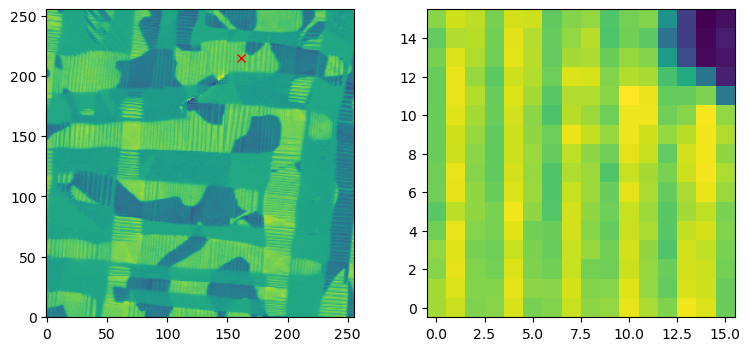

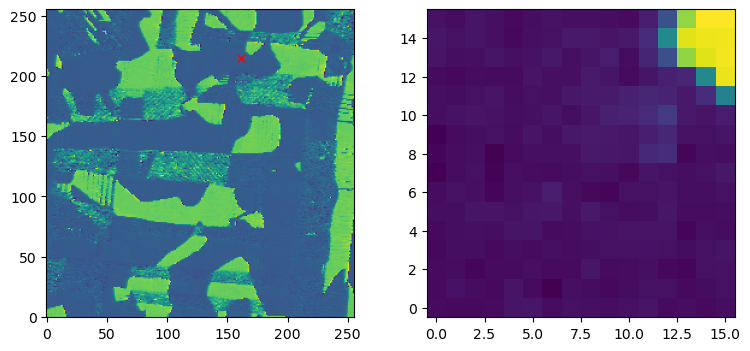

In [19]:
ws = 16
exp.update_param('ws', ws)

features, indices_all = load_image_and_features(topo, ws)

phase_patches, _ = load_image_and_features(phase, ws, norm=False)
# plt.imshow(features[30])
len(features)

index = 50040

fig, ax = plt.subplots(1,2, figsize=[9,4])
ax[0].imshow(topo, origin='lower')
ax[0].plot(indices_all[index][1], indices_all[index][0], 'rx')
ax[1].imshow(features[index], origin='lower')

fig, ax = plt.subplots(1,2, figsize=[9,4])
ax[0].imshow(phase, origin='lower')
ax[0].plot(indices_all[index][1], indices_all[index][0], 'rx')
ax[1].imshow(phase_patches[index], origin='lower')

In [20]:
save = 'output/20250522_PTKTO_DW4_'
patches = numpy_to_torch_for_conv(features)

exp.update_param('feature_all', features)
exp.update_param('indices_all', indices_all)
exp.update_param('patches_all', patches)
exp.update_param('phase_patches', phase_patches)


In [ ]:
# # Let's test the move_probe function first
# import time

# self = exp
# coord = indices_all[index][::-1]

# self.execute('ClearForce')
# self.execute('GoThere', wait=1)
# v0 = ae.read_spm(key=['PIDSLoop.0.Setpoint', 'PIDSLoop.1.Setpoint'])
# self.update_param('v0', v0)

# time.sleep(3)

# xsize, ysize = self.param['header']['FastScanSize'],self.param['header']['SlowScanSize']
# pos0 = np.array([xsize/2, ysize/2])
# x, y = coord
# x, y = self.corrected_measure_pos(x,y)

# r = np.array([x, y]) - pos0
# ae.move_tip(r=r, v0=self.param['v0'], s=self.param['sensitivity'])

## Seeding experiments

In [21]:
exp.execute('ScanSize', 1e-6, wait=1)
exp.execute('Points', 64, wait=1)
exp.execute('ScanRate', 2, wait=1)


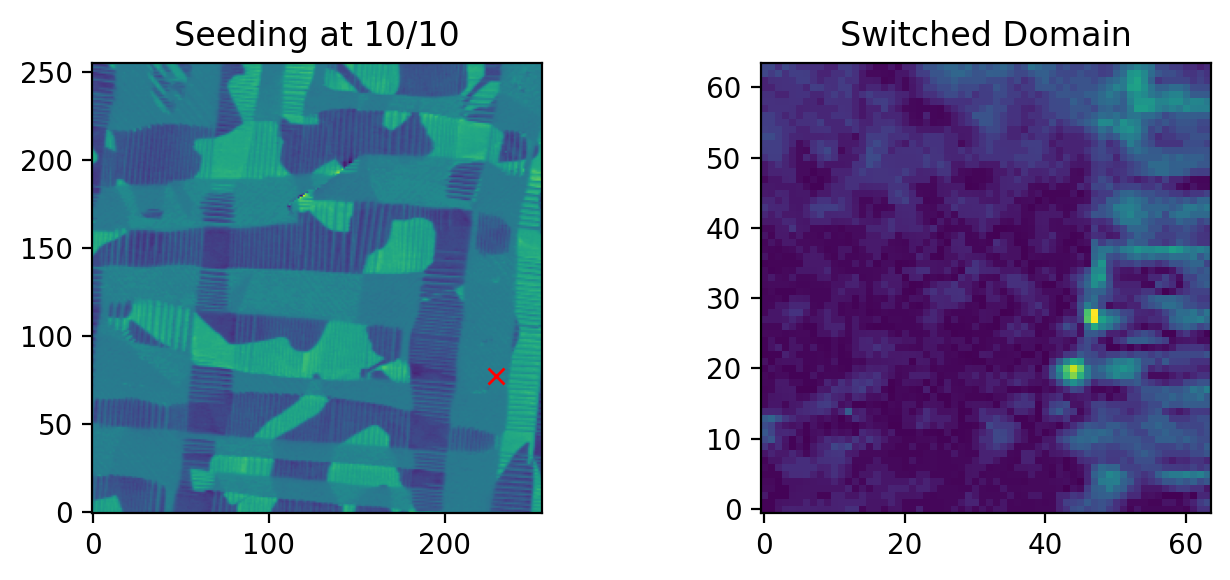

In [22]:
## Generate seeding
import time

exp.generate_seed(num=10, seed=42, save=save+'seeding', basename ='PTKTO_seed_')

## Active Learning experiments

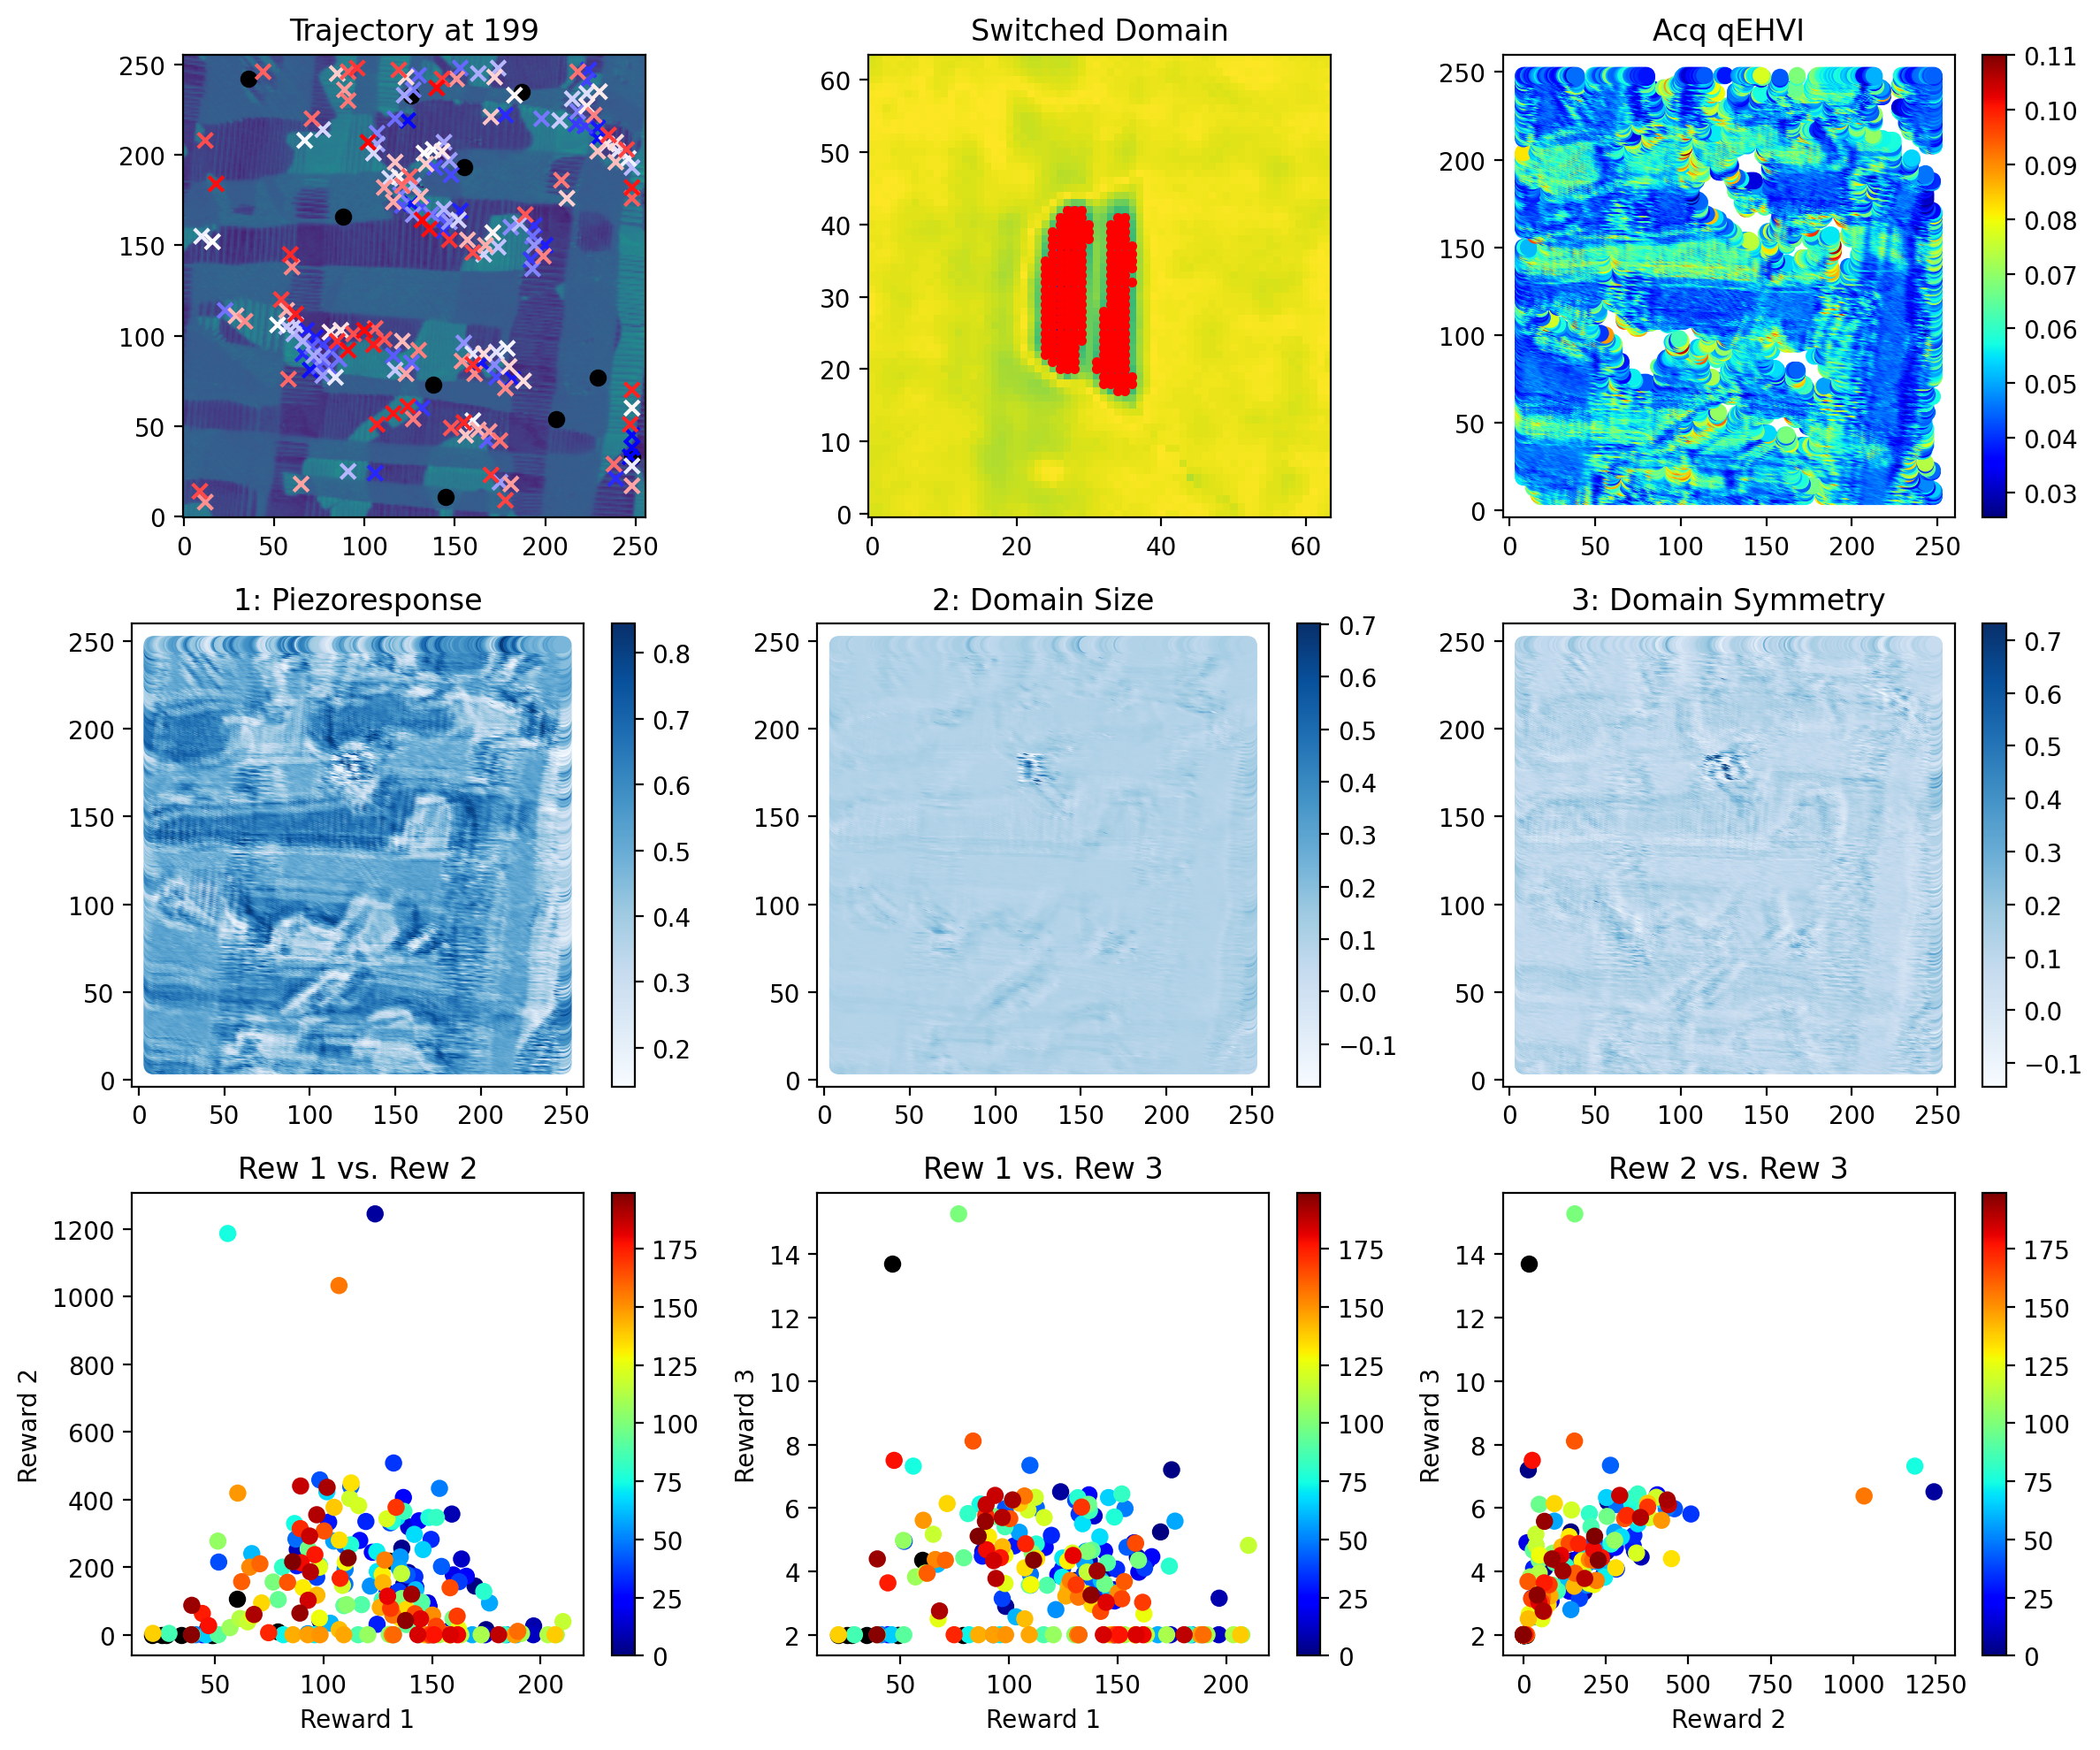

In [23]:
# Active learning steps

budget = 200
num_epochs = 50
scalarizer_zero = False
penalty_weight = 0.5  # Controls the importance of diversity vs. exploitation

exp.execute('ChangeName', 'PTKTO_training_')

models = exp.mobo_dkl(num=budget, num_epochs=num_epochs, restart=True, skip=10,
                      save=save+'training', basename='PTKTO_training_')

In [24]:
exp.execute('XOffset', exp.param['XOffset'], wait=1)
exp.execute('YOffset', exp.param['YOffset'], wait=1)
exp.execute('ScanSize', exp.param['header']['ScanSize'], wait=1)
exp.execute('ScanRate', exp.param['header']['ScanRate'], wait=1)
exp.execute('Points', 256, wait=1)

exp.execute('ChangeName', 'PTKTO_global_')

exp.execute('ScanDown', wait=3)
exp.check_files(max_wait=300)

True

In [ ]:
# TuneGraphButtonFunc("DoTuneSet90")

In [43]:
#self = exp

feature_extractor = []

for i in range(len(self.param['y_measured_seed'][0])):
#         print(i)
    feature_extractor.append(ConvNetFeatureExtractor(input_channels=1, output_dim=2).to(device))
    
window_size = self.param['ws']
patches = self.param['patches_all']
num_rewards = len(self.param['y_measured'][0])
num_epochs = 50

candidate_indices = self.param['indices_unmeasured']
X_candidates = torch.stack([patches[idx] for idx in candidate_indices]).to(device)
X_candidates_flat = X_candidates.reshape(X_candidates.size(0), -1)  # Flatten patches for distance calculation
# X_candidates = X_candidates.reshape(-1, window_size*window_size)# TODO: to make botorch acquisition functions compatible-> optimize_acqf_discrete
X_candidates = X_candidates.reshape(-1, 1, window_size*window_size) # Note this is when using acq f:n directly and not invoking  optimize_acqf_discrete

acquired_indices = self.param['indices_measured']
acquired_features = torch.stack([patches[idx] for idx in acquired_indices]).to(device)
acquired_features_flat = acquired_features.reshape(acquired_features.size(0), -1)

acq = 0
norm_factor = []
model_list = []
train_y = []

bounds = torch.stack([torch.ones(3), 1 * torch.ones(3)]).to(self.param['device'])

for i in range(num_rewards):
    model = self.train_model(i, feature_extractor[i], num_epochs=num_epochs,)
    # model.eval()
    model_list.append(model)
    y_train = torch.tensor(self.param['y_measured'][:, i], dtype=dtype).to(device)
    y_train = (y_train - y_train.min()) / (y_train.max() - y_train.min())
    train_y.append(y_train)
    norm_factor.append([y_train.max() - y_train.min(), y_train.min()])

train_y = torch.stack(train_y, dim=-1)
ref_point = torch.zeros(num_rewards, device=self.param['device'])

model = ModelListGP(*model_list)  # Properly initialize ModelListGP\
model.eval()

# Define reference point and make sure it's 2D
# ref_point = torch.zeros(2, device=device)  # For maximization

# Set up partitioning with properly shaped inputs
partitioning = FastNondominatedPartitioning(
    ref_point=ref_point,
    Y=train_y
)

acq_func = qExpectedHypervolumeImprovement(
        model=model,
        ref_point=ref_point.clone(),
        partitioning=partitioning,
    )

new_x, acq_value = optimize_acqf_discrete(
    acq_function=acq_func,
    # bounds=standard_bounds,
    choices=X_candidates_flat,
    q=1,
    # num_restarts=10,
    # options={"batch_limit": 5, "maxiter": 200},
    # sequential=True,
)

selected_idx = torch.where(
    (X_candidates_flat == new_x.view(1, -1)).all(dim=1)
)[0].item()
selected_index = [candidate_indices[selected_idx]]

self.param['acq'] = acq_func(X_candidates)

selected_indices = [selected_index]  # can be multiple indices if batch acquisition

# Measure the next index:
coord = self.param['indices_all'][selected_index][0]

RuntimeError: The size of tensor a (6) must match the size of tensor b (5) at non-singleton dimension 0

## Visualize the results

Text(0.5, 1.0, 'Predicted Coercive Voltage')

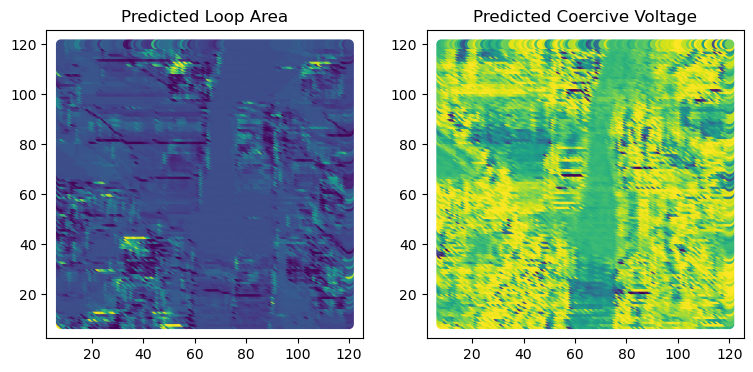

In [ ]:
import matplotlib.pyplot as plt
pred1, embeddings1 = embeddings_and_predictions(models[0], patches, device)
pred2, embeddings2 = embeddings_and_predictions(models[1], patches, device)

# plt.figure(figsize=[4,4])
# plt.scatter(indices_all[:,1], indices_all[:,0], c=pred1.mean.cpu().numpy())

fig, ax = plt.subplots(1,2, figsize=[9,4])
ax[0].scatter(indices_all[:,1], indices_all[:,0], c=pred1.mean.cpu().numpy())
# ax[0].plot(indices_all[index][1], indices_all[index][0], 'rx')
ax[1].scatter(indices_all[:,1], indices_all[:,0], c=pred2.mean.cpu().numpy())

ax[0].set_title('Predicted Loop Area')
ax[1].set_title('Predicted Coercive Voltage')


# Old codes

In [ ]:
spec = exp.load_ibw(folder=exp.folder, header=True, ss=True)

In [ ]:
spec.header

In [ ]:
plt.plot(spec.data[3])

In [ ]:
spec.header['PhaseOffset']

In [ ]:
# Initiate feature extractors
feature_extractor = []

for i in range(len(exp.param['y_measured_seed'][0])):
    print(i)
    feature_extractor.append(ConvNetFeatureExtractor(input_channels=1, output_dim=2).to(device))


In [ ]:
# Active learning steps

budget = 100
num_epochs = 200
scalarizer_zero = False
penalty_weight = 0.3  # Controls the importance of diversity vs. exploitation

window_size = ws

exp.update_param('budget', budget)
exp.update_param('num_epochs', num_epochs)
exp.update_param('scalarizer_zero', scalarizer_zero)

exp.update_param('X_measured', exp.param['X_measured_seed'])
exp.update_param('y_measured', exp.param['y_measured_seed'])
exp.update_param('indices_measured', exp.param['indices_measured_seed'])
exp.update_param('indices_unmeasured', exp.param['indices_unmeasured_seed'])

num_rewards = len(exp.param['y_measured'][0])

patches = exp.param['patches_all']

training = []

for step in range(budget):
    model_list = []
    y_train = []
    acq_func = []
    acq_values = []
    acq_values_penalized = []
    pareto_acq = []
    candidate_indices = exp.param['indices_unmeasured']
    X_candidates = torch.stack([patches[idx] for idx in candidate_indices]).to(device)
    X_candidates_flat = X_candidates.reshape(X_candidates.size(0), -1)  # Flatten patches for distance calculation
    # X_candidates = X_candidates.reshape(-1, window_size*window_size)# TODO: to make botorch acquisition functions compatible-> optimize_acqf_discrete
    X_candidates = X_candidates.reshape(-1, 1, window_size*window_size) # Note this is when using acq f:n directly and not invoking  optimize_acqf_discrete

    acquired_indices = exp.param['indices_measured']
    acquired_features = torch.stack([patches[idx] for idx in acquired_indices]).to(device)
    acquired_features_flat = acquired_features.reshape(acquired_features.size(0), -1)
    # Initialize penalties
    penalties = torch.zeros_like(exp.param['y_measured'][:, 0]).to(device)
    if len(acquired_indices) > 0:  # Only apply penalty if there are acquired points
        # Calculate pairwise distances between candidates and acquired points
        # Using a more numerically stable distance calculation
        candidates_norm = (X_candidates_flat ** 2).sum(dim=1, keepdim=True)  # [n_candidates, 1]
        acquired_norm = (acquired_features_flat ** 2).sum(dim=1, keepdim=True).t()  # [1, n_acquired]
        # Calculate the dot product
        dot_product = torch.mm(X_candidates_flat, acquired_features_flat.t())  # [n_candidates, n_acquired]
        # Calculate squared distances
        squared_distances = candidates_norm + acquired_norm - 2 * dot_product  # [n_candidates, n_acquired]
        # Find minimum distance for each candidate point
        min_distances, _ = torch.min(squared_distances, dim=1)  # [n_candidates]
        # Convert to penalties: high penalty for small distances
        threshold = 1e-6
        min_distances = torch.clamp(min_distances, min=threshold)
        # Scale the penalties - adaptive scaling based on data distribution
        proximity_scale = torch.mean(min_distances) * 0.5  # Adjust this value to control penalty strength
        penalties = torch.exp(-min_distances / proximity_scale)

    acq = 0
    for i in range(num_rewards):
        model = exp.train_model(i, feature_extractor[i], num_epochs=num_epochs,)
        model.eval()
        model_list.append(model)
        y_train = torch.tensor(exp.param['y_measured'][:, i], dtype=dtype).to(device)
        y_train = (y_train - y_train.min()) / (y_train.max() - y_train.min())

        acq_func.append(LogExpectedImprovement(model=model, best_f=y_train.max().to(device)))
        acq_temp =  acq_func[i](X_candidates)
        acq_values.append((acq_temp - acq_temp.min()) / (acq_temp.max() - acq_temp.min()))
        acq_values_penalized.append(acq_values[i] - penalty_weight * penalties)
        acq += acq_values[i].cpu().detach().numpy()

    # acq = acq_values1_penalized.cpu().detach().numpy() + acq_values2_penalized.cpu().detach().numpy()

    exp.param['acq_values'] = acq

    # Apply penalties to acquisition values
    # Stack acquisition values into a single tensor of shape (Q, 2)
    acq_matrix = torch.stack(acq_values_penalized, dim=1)
    # Determine Pareto optimal points
    pareto_mask = is_non_dominated(acq_matrix)
    # Convert mask to boolean numpy array
    pareto_mask_np = pareto_mask.cpu().numpy()
    # Extract Pareto optimal indices
    pareto_indices = np.where(pareto_mask_np)[0]
    if len(pareto_indices) == 0:
        # If no Pareto optimal points, fallback to selecting the point with the highest acq_1
        selected_candidate_idx = torch.argmax(acq_values_penalized[0]).item()
    else:
        # Extract acquisition values for Pareto optimal points
        aggregate_acq = 0
        for j in range(num_rewards):
            aggregate_acq +=  acq_values_penalized[j][pareto_mask]  # Simple sum; can also use weighted sum or average
        # Select the Pareto point with the highest aggregate acquisition value
        selected_pareto_idx = torch.argmax(aggregate_acq).item()
        selected_candidate_idx = pareto_indices[selected_pareto_idx]
    # Map the selected candidate index to the original dataset index
    selected_index = candidate_indices[selected_candidate_idx]
    selected_indices = [selected_index]  # can be multiple indices if batch acquisition

    # Measure the next index:
    coord = exp.param['indices_all'][selected_index]

    if step % 10 == 0:
        y_measured, obj = exp.measure(coord, n=3, spec=True, center=True, basename='PTKTO_training_')
        training.append(np.array(divide_ss(obj, n=3)))
        w = ae.tune_probe(num=2, path=r"C:\Users\Asylum User\Documents\buffer\Tune.ibw",
                      out=True, center=400e3, width=75e3)
    else:
        y_measured, obj = exp.measure(coord, n=3, spec=True, center=False, basename='PTKTO_training_')
        training.append(np.array(divide_ss(obj, n=3)))

    exp.update_param('indices_unmeasured_prev', exp.param['indices_unmeasured'])

    exp.update_param('X_measured', torch.cat((exp.param['X_measured'], torch.tensor(coord).unsqueeze(0)), dim=0))
    exp.update_param('y_measured', torch.cat((exp.param['y_measured'], torch.tensor(y_measured).unsqueeze(0)), dim=0))
    exp.update_param('indices_measured', torch.cat((torch.tensor(exp.param['indices_measured']), torch.tensor([selected_index])), dim=0))
    exp.update_param('indices_unmeasured', torch.cat((torch.tensor(exp.param['indices_unmeasured'][:selected_candidate_idx]),
                                                      torch.tensor(exp.param['indices_unmeasured'][selected_candidate_idx+1:])), dim=0))

    exp.plot_pareto_front(step, obj)

    print(f"**************************done BO step {step +1}", end='\r')
    # print("total points in pareto_indices",len(pareto_indices))


np.savez('{}.npz'.format(save='training'), X_measured=exp.param['X_measured'],
         y_measured=exp.param['y_measured'], idx=exp.param['indices_measured'], traces=training)

In [ ]:
np.savez('{}.npz'.format(save+'training'), X_measured=exp.param['X_measured'],
         y_measured=exp.param['y_measured'], idx=exp.param['indices_measured'], traces=training)

In [ ]:
import pickle

with open('{}.pickle'.format(save), 'wb') as fopen:
    pickle.dump(exp.param, fopen)

In [ ]:
exp.param['indices_unmeasured'].shape

In [ ]:
exp.param['y_measured'].shape

In [ ]:
selected_index

In [ ]:
selected_candidate_idx

In [ ]:
X_candidates.shape

In [ ]:
acq_values[0].shape

In [ ]:
##############################-> plot
predictions_data = Active_learning_statistics
# Extract necessary data
# img = np.array(predictions_data["img"])  # Image or grid for background visualization
img = topo
seed_indices = np.array(predictions_data["seed_indices"])  # Initial sampled indices (referring to positions in indices_all)

unacquired_indices = np.array(predictions_data["unacquired_indices"])  # Remaining indices
indices_all = np.array(predictions_data["indices_all"])  # All possible indices (coordinates)
# Map seed_indices and unacquired_indices to their coordinates in indices_all
seed_coords = indices_all[seed_indices]
unacquired_coords = indices_all[unacquired_indices]
# Calculate acquired indices as the complement of unacquired and seed indices
acquired_indices = np.setdiff1d(np.arange(indices_all.shape[0]), np.union1d(seed_indices, unacquired_indices), assume_unique=True)
acquired_coords = indices_all[acquired_indices]
# Plot the results
plt.figure(figsize=(8, 5))
# Display the image or grid as the background
plt.imshow(img, cmap="gray", origin="lower")
# Plot the seed points in blue
plt.scatter(seed_coords[:, 1], seed_coords[:, 0], c="b", label="Seed Points", marker="o")
time_order = np.arange(len(acquired_coords))  # Create a sequence representing time
scatter = plt.scatter(acquired_coords[:, 1], acquired_coords[:, 0], c=time_order, cmap="bwr", label="Acquired Points", marker="x")
# Plot the unacquired points in green
# plt.scatter(unacquired_coords[:, 1], unacquired_coords[:, 0], c="g", label="Unacquired Points", marker="+")
# Set plot labels and legend
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Active Learning Trajectory")
plt.legend()
plt.grid(True)
# Add a colorbar and label it as "Steps"
cbar = plt.colorbar(scatter)
cbar.set_label("Steps")
# plt.savefig(Path(res_dir) / "AL_traj.png")
plt.show()
plt.close()


In [ ]:
res1 = list(acquired_data1.values())
res2 = list(acquired_data2.values())

plt.figure(figsize=[5,4])
plt.scatter(res1[:10], res2[:10], c='k')
im = plt.scatter(res1[10:], res2[10:], c=np.arange(len(acquired_data1)-10), cmap=plt.cm.jet)


plt.colorbar(im, ax=plt.gca())
plt.xlabel('Reward 1')
plt.ylabel('Reward 2')


In [ ]:
import matplotlib.pyplot as plt
pred1, embeddings1 = embeddings_and_predictions(model1, patches, device)
pred2, embeddings2 = embeddings_and_predictions(model2, patches, device)

# plt.figure(figsize=[4,4])
# plt.scatter(indices_all[:,1], indices_all[:,0], c=pred1.mean.cpu().numpy())

fig, ax = plt.subplots(1,2, figsize=[9,4])
ax[0].scatter(indices_all[:,1], indices_all[:,0], c=pred1.mean.cpu().numpy())
# ax[0].plot(indices_all[index][1], indices_all[index][0], 'rx')
ax[1].scatter(indices_all[:,1], indices_all[:,0], c=pred2.mean.cpu().numpy())

ax[0].set_title('Predicted Reward 1')
ax[1].set_title('Predicted Reward 2')
